## MovieLens 20M Dataset Recommender System - 02_ExploratoryDataAnalysis

This dataset describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. These data were created by users between January 09, 1995 and March 31, 2015. This dataset was generated on March 31, 2015, and updated on October 17, 2016 to update links.csv and add genome-* files. 

Users were selected at random for inclusion. All selected users had rated at least 20 movies. No demographic information is included. Each user is represented by an id, and no other information is provided,

The data are contained in six files, 'genome-scores.csv', 'genome-tags.csv', 'links.csv', 'movies.csv', 'ratings.csv' and 'tags.csv'.

We would like to use it to build a model of recommender systems.

This is the second part of the study: Exploratory Data Analysis.

### Content

### 1. Import Modules and Read Data File

#### 1.1 Import  Necessary Modules

First let's import all necessary modules.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from surprise import Dataset, accuracy, Reader
from surprise import SVD, SVDpp, KNNBasic, BaselineOnly, SlopeOne, CoClustering, NMF
from surprise.model_selection import train_test_split, cross_validate, GridSearchCV

#### 1.2 Read Data File

Let's then read data file.

In [3]:
# First, read the rating file.
ratings = pd.read_csv('./ml-20m/new_ratings.csv')

In [4]:
# check the first few rows
ratings.head()

,userId,movieId,rating,title,genres
0,24,5,2.0,Father of the Bride Part II (1995),Comedy
1,24,6,4.0,Heat (1995),Action|Crime|Thriller
2,24,7,3.0,Sabrina (1995),Comedy|Romance
3,24,10,3.0,GoldenEye (1995),Action|Adventure|Thriller
4,24,16,5.0,Casino (1995),Crime|Drama


In [5]:
# count the values of rating
ratings['rating'].value_counts()

4.0    154619
3.0    110546
3.5     70359
5.0     62833
4.5     43520
2.0     38035
2.5     26799
1.0     15336
1.5      7616
0.5      5741
Name: rating, dtype: int64

In [6]:
# calculate the average rating
ratings['rating'].mean()

3.509636648213312

### 2. Performance Evaluations on a Few Rating Prediction Models

Our first task is to predict the user's rating. The basic idea is to split the rating data into train set and test, and use train set to build prediction models, and use the test set to test the model performance. This is the typical process for machine learning.  

So let's try a few models and see how they work. The first one is a basic model of "Mean Combination". Then we will use the module of popular "surprise", and try a few models from it.

"Surprise" is a powerful module for building recommender system. The developer also give very detailed instruction for how to use the model. Please refer to their webpage for details: (https://surprise.readthedocs.io/en/stable/index.html)

We will use the Root Mean Square Error (RMSE) as the model performance evaluation metrics. 

#### 2.1 The Mean Combination Model

This is a very basic model created by me. The idea is very simple: For every user/movie pair in the test data, calculate the average rating for this movie in train data, and then the average mean from this user to all movies in train data. Finally we combine the two means and use the combination as the rating prediction. 

To get the minimize the prediction error, we need to study what is the best combination. We will use different combination ratios and calculate the error for each ratio. Then we will be able to get the best ratio. 
Final Mean = Movie Average Rating * ratio + User Average Rating * (1-ratio)

##### 2.1.1 Shuffle the Data and Split Train Test Data Sets

In [7]:
# shuffle the rating data
ratings_shuffled = ratings.sample(frac=1, ignore_index=True, random_state=101)

In [8]:
# check the data size before and after the shuffle
ratings_shuffled.shape, ratings.shape

((535404, 5), (535404, 5))

In [9]:
# define the split position (train test data size ratio)
split = int(ratings_shuffled.shape[0] * 0.9)

In [10]:
# split the data to train and test
train = ratings_shuffled.loc[:split-1,]
test = ratings_shuffled.loc[split:,]

In [11]:
# check the train and test data size
train.shape, test.shape

((481863, 5), (53541, 5))

##### 2.1.2 Define Functions for the Model

We need to define functions for calculating RMSE, for performance evaluation, and for rating prediction.

In [12]:
# list the movies in the train data
movies_in_train = train['movieId'].unique()

In [13]:
# list the movies in the total rating data
movies_in_rating = ratings['movieId'].unique()

In [14]:
# list the users in the train data
users_in_train = train['userId'].unique()

In [15]:
users_in_test = test['userId'].values
movies_in_test = test['movieId'].values

In [16]:
# Define the function to compute Root Mean Squared Error
def compute_rmse(y_pred, y_true):
    
    return np.sqrt(np.mean(np.power(y_pred - y_true, 2)))

In [17]:
# RMSE-based predictive performance evaluation with pandas
def evaluate(estimate_f):
    estimated = []
    for i in range(len(test)):
        if i%1000==0: print('i=',i,' total len=',len(test))
        user = users_in_test[i]
        movie = movies_in_test[i]
        est = estimate_f(user, movie)
        estimated.append(est)
#    print(estimated)
    real = test.rating.values
#    print('len real:', len(real))
#    print('type real', type(real))
    return compute_rmse(estimated, real)

In [18]:
# RMSE-based predictive performance evaluation for the mean combination model
def evaluate_mc(ratio):
    """ RMSE-based predictive performance evaluation with pandas. """
    estimated = []
    for i in range(len(test)):
        if i%1000==0: print('i=',i,' total len=',len(test))
        user = users_in_test[i]
        movie = movies_in_test[i]
        est = means_combination(user, movie, ratio)
        estimated.append(est)
#    print(estimated)
    real = test.rating.values
    return compute_rmse(estimated, real)

In [19]:
# define rating prediction function (means combination)
def means_combination(user_id, movie_id, ratio):
    movie_condition = movie_id in movies_in_train  # True if the movie is in train
    user_condition = user_id in users_in_train    # True if the user is in train

    if movie_condition:
        if user_condition:
            mean_movie = train[train['movieId']==movie_id]['rating'].mean()  # movie average rating from train data
            mean_user = train[train['userId']==user_id]['rating'].mean() # user average rating from train data
            return (mean_movie*ratio + mean_user*(1.0-ratio))     # It is found that this combination of two means 
        else:                                           # gives the best performance
            return train[train['movieId']==movie_id]['rating'].mean() # if user is not in train, return movie avg rating
    elif user_condition:
        return train[train['userId']==user_id]['rating'].mean() # if movie is not in train, return user avg rating
    else:
        return 3.5

##### 2.1.3 Parameter Tuning for Combination Ratio

We need to searh for the combination ratio which gives the best performance (lowest RMSE).

In [20]:
# tuning the mean combination ratio
ratio = []
rmse = []

for r in np.arange(0.45, 0.7, 0.05):
    print('r=', r)
    error = evaluate_mc(r)
    ratio.append(r)
    rmse.append(error)

r= 0.45
i= 0  total len= 53541
i= 1000  total len= 53541
i= 2000  total len= 53541
i= 3000  total len= 53541
i= 4000  total len= 53541
i= 5000  total len= 53541
i= 6000  total len= 53541
i= 7000  total len= 53541
i= 8000  total len= 53541
i= 9000  total len= 53541
i= 10000  total len= 53541
i= 11000  total len= 53541
i= 12000  total len= 53541
i= 13000  total len= 53541
i= 14000  total len= 53541
i= 15000  total len= 53541
i= 16000  total len= 53541
i= 17000  total len= 53541
i= 18000  total len= 53541
i= 19000  total len= 53541
i= 20000  total len= 53541
i= 21000  total len= 53541
i= 22000  total len= 53541
i= 23000  total len= 53541
i= 24000  total len= 53541
i= 25000  total len= 53541
i= 26000  total len= 53541
i= 27000  total len= 53541
i= 28000  total len= 53541
i= 29000  total len= 53541
i= 30000  total len= 53541
i= 31000  total len= 53541
i= 32000  total len= 53541
i= 33000  total len= 53541
i= 34000  total len= 53541
i= 35000  total len= 53541
i= 36000  total len= 53541
i= 370

In [21]:
# create a dataframe to include the tuning results
rmse_df = pd.DataFrame({'ratio':ratio, 'rmse': rmse})

In [22]:
rmse_df

,ratio,rmse
0,0.45,0.869475
1,0.50,0.867911
2,0.55,0.867312
3,0.60,0.867681
4,0.65,0.869017


Let's plot the RMSE vs ratio. 

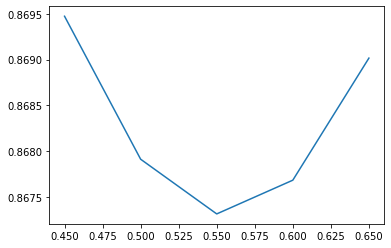

In [23]:
# plot the tuning result
plt.plot(rmse_df['ratio'], rmse_df['rmse'])

In [24]:
# define the final RMSE for the mean combination model
rmse_mc = evaluate_mc(0.55)

i= 0  total len= 53541
i= 1000  total len= 53541
i= 2000  total len= 53541
i= 3000  total len= 53541
i= 4000  total len= 53541
i= 5000  total len= 53541
i= 6000  total len= 53541
i= 7000  total len= 53541
i= 8000  total len= 53541
i= 9000  total len= 53541
i= 10000  total len= 53541
i= 11000  total len= 53541
i= 12000  total len= 53541
i= 13000  total len= 53541
i= 14000  total len= 53541
i= 15000  total len= 53541
i= 16000  total len= 53541
i= 17000  total len= 53541
i= 18000  total len= 53541
i= 19000  total len= 53541
i= 20000  total len= 53541
i= 21000  total len= 53541
i= 22000  total len= 53541
i= 23000  total len= 53541
i= 24000  total len= 53541
i= 25000  total len= 53541
i= 26000  total len= 53541
i= 27000  total len= 53541
i= 28000  total len= 53541
i= 29000  total len= 53541
i= 30000  total len= 53541
i= 31000  total len= 53541
i= 32000  total len= 53541
i= 33000  total len= 53541
i= 34000  total len= 53541
i= 35000  total len= 53541
i= 36000  total len= 53541
i= 37000  tota

We can see that the RMSE is the minimum when ratio = 0.55. So we would like to use this value for evaluating the mean combination model.

In [25]:
rmse_mc

0.8673124600104097

So the RMSE for the combination mean model is 0.867.

#### 2.2 The Singular Value Decomposition (SVD) Model

The singular Value Decomposition is a popular model for recommender systems. Let's have a look on its performance.

All models below in Part 2 are from the module "surprise".

##### 2.2.1 Prepare the Data for the Model

In [26]:
# All models in surprise use a special data type. First we need to convert the pandas dataframe to that special type.
# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
new_ratings = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [27]:
# split the rating into train data and test data
trainset, testset = train_test_split(new_ratings, test_size=.10)

##### 2.2.2 Use SVD Model for Cross Validation

In [28]:
# create SVD model
svd =  SVD()

In [29]:
# fit model and predict rating for test data
svd.fit(trainset)
predictions = svd.test(testset)

In [30]:
# print the prediction accuracy (RMSE)
accuracy.rmse(predictions)

RMSE: 0.7854


0.7854476339506444

In [31]:
# cross validation on the SVD model
cross_validate(svd, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7910  0.7933  0.7922  0.7872  0.7917  0.7911  0.0021  
Fit time          31.97   32.98   31.13   32.31   31.91   32.06   0.60    
Test time         1.09    1.27    1.35    1.44    1.27    1.28    0.12    


{'test_rmse': array([0.79097322, 0.79332503, 0.79217944, 0.78724618, 0.79168907]),
 'fit_time': (31.9696364402771,
  32.97612738609314,
  31.132506132125854,
  32.309486627578735,
  31.91457724571228),
 'test_time': (1.087111234664917,
  1.2664477825164795,
  1.3547816276550293,
  1.4407968521118164,
  1.267171859741211)}

So the RMSE for SVD model is 0.791 (mean RMSE from the cross validation results).

In [32]:
rmse_svd = 0.792

#### 2.3 The Singular Value Decomposition Plus Plus (SVD++) Model

SVD++ is an extension of SVD with taking into account implicit ratings.

In [33]:
# create the SVD++ model 
svdpp = SVDpp()

In [34]:
# Fit the model
svdpp.fit(trainset)

In [35]:
# predict the rating in the test data
pred_svdpp = svdpp.test(testset)

In [36]:
cross_validate(svdpp, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7786  0.7762  0.7795  0.7749  0.7822  0.7783  0.0025  
Fit time          1936.29 1906.43 1922.18 1890.28 1865.95 1904.23 24.56   
Test time         39.32   38.38   38.33   38.78   38.48   38.66   0.37    


{'test_rmse': array([0.77860741, 0.77624688, 0.77947139, 0.77491023, 0.78216526]),
 'fit_time': (1936.2895181179047,
  1906.4337499141693,
  1922.1777157783508,
  1890.2785606384277,
  1865.950136423111),
 'test_time': (39.31971621513367,
  38.379828453063965,
  38.32975244522095,
  38.78139305114746,
  38.47559142112732)}

So the RMSE for SVD++ model is 0.779 (mean RMSE from the cross validation results).

In [37]:
rmse_svdpp = 0.779

#### 2.4 The Basic K Nearest Neighbors (KNN) Model

Basic KNN is a basic collaborative filtering algorithm. Let's do the cross validation to see its performance.

In [38]:
knn = KNNBasic()

In [39]:
cross_validate(knn, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8359  0.8362  0.8360  0.8328  0.8349  0.8352  0.0013  
Fit time          13.44   13.30   14.44   13.21   14.04   13.69   0.48    
Test time         49.67   50.38   52.54   52.59   51.79   51.39   1.17    


{'test_rmse': array([0.8359369 , 0.83623625, 0.83597533, 0.83283865, 0.83492352]),
 'fit_time': (13.43607497215271,
  13.303571701049805,
  14.438277006149292,
  13.206847667694092,
  14.042703628540039),
 'test_time': (49.669597148895264,
  50.37755084037781,
  52.54126811027527,
  52.58683753013611,
  51.7905855178833)}

So the RMSE for the basic KNN model is 0.835 (mean RMSE from the cross validation results).

In [40]:
rmse_knn = 0.835

#### 2.5 The SlopeOne Model

Next let's try the SlopeOne model. It is a simple yet accurate collaborative filtering algorithm,  a straightforward implementation of the SlopeOne algorithm [lemire2007a]

In [41]:
slopeone = SlopeOne()

In [42]:
cross_validate(slopeone, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SlopeOne on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8173  0.8152  0.8218  0.8185  0.8202  0.8186  0.0023  
Fit time          7.61    7.56    8.37    7.66    7.72    7.78    0.30    
Test time         29.03   28.98   29.27   29.37   28.28   28.99   0.38    


{'test_rmse': array([0.8172706 , 0.81521099, 0.82177156, 0.8185459 , 0.82023358]),
 'fit_time': (7.609397888183594,
  7.560887336730957,
  8.367907762527466,
  7.658310174942017,
  7.724998474121094),
 'test_time': (29.025391578674316,
  28.978322744369507,
  29.269102096557617,
  29.373017072677612,
  28.283018589019775)}

So the RMSE for the SlopeOne model is 0.819 (mean RMSE from the cross validation results).

In [43]:
rmse_slopeone = 0.819

#### 2.6 The CoClustering Model

Let's then try the CoClustering Model.

In [44]:
coclust = CoClustering()

In [45]:
cross_validate(coclust, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm CoClustering on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8450  0.8387  0.8431  0.8381  0.8404  0.8411  0.0026  
Fit time          14.29   14.04   14.64   14.50   13.97   14.29   0.26    
Test time         1.08    1.15    1.14    1.25    1.73    1.27    0.23    


{'test_rmse': array([0.84495804, 0.8386692 , 0.84306985, 0.8381466 , 0.84041661]),
 'fit_time': (14.28555965423584,
  14.039444923400879,
  14.642492294311523,
  14.501892328262329,
  13.97287106513977),
 'test_time': (1.0831515789031982,
  1.1482033729553223,
  1.1384305953979492,
  1.253756046295166,
  1.7263221740722656)}

So the RMSE for the CoClustering model is 0.841 (mean RMSE from the cross validation results).

In [46]:
rmse_coclust = 0.841

#### 2.7 The BaselineOnly Model

In [47]:
blo = BaselineOnly()

In [48]:
cross_validate(blo, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8203  0.8179  0.8207  0.8234  0.8216  0.8208  0.0018  
Fit time          1.14    1.34    1.29    1.13    1.30    1.24    0.09    
Test time         1.01    1.06    1.14    0.95    1.63    1.16    0.25    


{'test_rmse': array([0.8203095 , 0.81788195, 0.82067813, 0.82341599, 0.82155667]),
 'fit_time': (1.1375494003295898,
  1.3401455879211426,
  1.2904462814331055,
  1.126648187637329,
  1.2971088886260986),
 'test_time': (1.0060384273529053,
  1.0590133666992188,
  1.1353545188903809,
  0.9494845867156982,
  1.6345925331115723)}

So the RMSE for the BaselineOnly model is 0.821 (mean RMSE from the cross validation results).

In [49]:
rmse_blo = 0.821

#### 2.8 The Non-negative Matrix Factorization (NMF) Model

In [50]:
nmf = NMF()

In [51]:
cross_validate(nmf, new_ratings, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8277  0.8285  0.8267  0.8298  0.8279  0.8281  0.0010  
Fit time          34.68   34.65   34.48   34.53   35.18   34.70   0.25    
Test time         1.26    1.42    1.56    1.49    1.37    1.42    0.10    


{'test_rmse': array([0.82768769, 0.82850558, 0.82670006, 0.82975012, 0.8278745 ]),
 'fit_time': (34.67535662651062,
  34.647749185562134,
  34.478904008865356,
  34.533287525177,
  35.184574604034424),
 'test_time': (1.2585718631744385,
  1.4165878295898438,
  1.5630097389221191,
  1.4918880462646484,
  1.3720600605010986)}

So the RMSE for the NMF model is 0.827 (mean RMSE from the cross validation results).

In [52]:
rmse_nmf = 0.827

#### 2.9 Evaluation on Model Performances

We have tried different models and get some results of the prediction's RMSE. Let's plot those RMSEs with a bar plot as shown below. We can see that the RMSE for SVD++ model is the smallest (RMSE=0.779), which means this mdoel gives the best performance . So we would like to use this model as our final. 

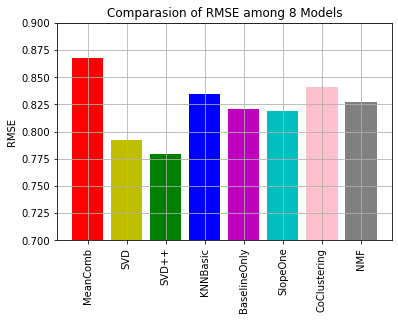

In [53]:
# plot the final RMSEs from all the models. 
models = ['MeanComb','SVD', 'SVD++', 'KNNBasic', 'BaselineOnly', 'SlopeOne', 'CoClustering', 'NMF']
rmses = [rmse_mc, rmse_svd, rmse_svdpp, rmse_knn, rmse_blo, rmse_slopeone, rmse_coclust, rmse_nmf]
colors = ['r','y','g', 'b', 'm', 'c', 'pink','gray']
plt.bar(models, rmses, color=colors)
plt.ylim(0.7, 0.9)
plt.grid(True)
plt.ylabel('RMSE')
plt.title('Comparasion of RMSE among 8 Models')
plt.xticks(rotation=90)
plt.show()

#### 2.10 Grid Search Cross Validation on Hyperparameters for SVD++

Let's do the GridSearch cross validation to see if we could get better performance on SVD++.

In [54]:
# Grid search cross validation for the SVD++ model
param_grid = {
    "n_epochs": [20, 25],
    "lr_all": [0.007, 0.009],
    "reg_all": [0.04, 0.06]
}
gridsearch = GridSearchCV(SVDpp, param_grid, measures=["rmse"], cv=3)

In [55]:
gridsearch.fit(new_ratings)

In [56]:
gridsearch.best_score["rmse"], gridsearch.best_params["rmse"]

(0.7823555968406262, {'n_epochs': 25, 'lr_all': 0.009, 'reg_all': 0.06})

The cross validation takes very long time (~8 hours) and did not give a better performance. So we will use the default options.

Let's create a dataframe from the predictions from the SVD++ model.

In [57]:
pred_df = pd.DataFrame(pred_svdpp)

In [58]:
pred_df.head()

,uid,iid,r_ui,est,details
0,94519,8949,5.0,3.953386,{'was_impossible': False}
1,83882,1188,4.0,3.463672,{'was_impossible': False}
2,97195,288,4.0,3.390564,{'was_impossible': False}
3,107806,5147,2.0,4.147112,{'was_impossible': False}
4,40058,10,3.0,3.709028,{'was_impossible': False}


In [59]:
# drop unnecessary column and change the column names
pred_df.drop("details", inplace=True, axis=1)
pred_df = pred_df.rename(columns = {'uid':'userId', 'iid':'movieId', 'r_ui':'actual_rating', 'est':'predicted_rating'})

In [60]:
pred_df.head()

,userId,movieId,actual_rating,predicted_rating
0,94519,8949,5.0,3.953386
1,83882,1188,4.0,3.463672
2,97195,288,4.0,3.390564
3,107806,5147,2.0,4.147112
4,40058,10,3.0,3.709028


### 3. User Defined Collaborative Filtering Algorithm

In part 2 above, quite a few collaborative filtering models have been tested. Here I would like to build my own collaborative filtering algorithm, based on the conception of collaborative filtering. 

Basically there are two kinds of collaborative filtering: user based and item based. For user based collaborative filtering, it is believed that people who gave similar ratings in the past would give similar ratings in the future. So you can use similar people’s rating to predict; For item based collaborative filtering, you will compare items the specific user has rated on, and choose the item which is similar to the one you need to predict.

So let's start from user based collaborative filtering.

#### 3.1 User Based Collaborative Filtering

In a user based collaborative filtering, a similarity function is used to calculate the similarity between users, and use rating from similar user to predict one's rating. 

In this study, we will use the pearson correlation coefficient as the similarity function, and use the rating from the user who is the most correlated to our target user. To ensure the best prediction, we will use this rating only if the correlation coefficent is large enough (>0.85), otherwise we will use the mean combination as mentioned before. 

So this is the precedure: to predict the rating from a user/movie pair, first, in the train data, find all users who have watched the movie. Then in those users, find the one which has the highest correlation with the specific user, and then use the rating from this highest correlated user on this movie as the prediction to the rating.

In [61]:
# first let's create a pivot table from the train dataset
pivot_rating_user = train.pivot_table(index = ["movieId"], columns = ["userId"],values = "rating", fill_value=0)

In [73]:
# find the most correlated user in group "users"
def user_corr(user, users):
    if user in users_in_train:
   #     print('movie in movies_in_train')
        user_rated = pivot_rating_user[user]
   #     print(movie_watched)
        similarity = pivot_rating_user[users].corrwith(user_rated)  
        similarity = similarity.sort_values(ascending=False)
        return similarity.index.values[0], similarity.values[0]

In [71]:
# define the collaborative filtering function to predict the rating on a specific user/movie pair
def user_based_collab(user_id, movie_id):
    movie_cond = movie_id in movies_in_train  # the movie exist in train data
    user_cond = user_id in users_in_train    # the user exist in train data
 #   print(user_cond, movie_cond)
    if movie_cond:
        if user_cond: 
            users_watched_the_movie = train[train['movieId']==movie_id]['userId'].values #  users who watched the movie
 #           print('movies_user_watched',movies_user_watched)
            matched_user, corr = user_corr(user_id, users_watched_the_movie)  # find the most corr user and the corr coeff
  #          print('matched_movie',matched_movie)
            if (corr>0.85):  # if the corr is great enough
                return train[(train['movieId']==movie_id)&(train['userId']==matched_user)]['rating'].values[0]
            else:  # if the corr is small
                mean_movie = train[train['movieId']==movie_id]['rating'].mean()  # movie average rating from train data
                mean_user = train[train['userId']==user_id]['rating'].mean() # user average rating from train data
                return mean_movie*0.55 + mean_user*0.45  
        else:  # if movie exist but user does not exist
            return train[train['movieId']==movie_id]['rating'].mean()
    elif user_cond:  # if user exist but movie does not exist
        return train[train['userId']==user_id]['rating'].mean()
    else:  # if both movie and user does not exist
        return 3.5

In [77]:
rmse_ubc = evaluate(user_based_collab)

i= 0  total len= 53541
i= 1000  total len= 53541
i= 2000  total len= 53541
i= 3000  total len= 53541
i= 4000  total len= 53541
i= 5000  total len= 53541
i= 6000  total len= 53541
i= 7000  total len= 53541
i= 8000  total len= 53541
i= 9000  total len= 53541
i= 10000  total len= 53541
i= 11000  total len= 53541
i= 12000  total len= 53541
i= 13000  total len= 53541
i= 14000  total len= 53541
i= 15000  total len= 53541
i= 16000  total len= 53541
i= 17000  total len= 53541
i= 18000  total len= 53541
i= 19000  total len= 53541
i= 20000  total len= 53541
i= 21000  total len= 53541
i= 22000  total len= 53541
i= 23000  total len= 53541
i= 24000  total len= 53541
i= 25000  total len= 53541
i= 26000  total len= 53541
i= 27000  total len= 53541
i= 28000  total len= 53541
i= 29000  total len= 53541
i= 30000  total len= 53541
i= 31000  total len= 53541
i= 32000  total len= 53541
i= 33000  total len= 53541
i= 34000  total len= 53541
i= 35000  total len= 53541
i= 36000  total len= 53541
i= 37000  tota

In [78]:
print('RMSE for user based collaborative filtering is:', rmse_ubc)

RMSE for user based collaborative filtering is: 0.8673124600104097


#### 3.2 Item Based Collaborative Filtering

Let's then think of the item based collaborative filtering. It is quite similar to the user based collaboratie filtering. The only difference is that instead of considering the similarity between users, now we need to consider the similarity between two movies. Again let's use pearson correlation coefficient.

So this is the precedure: to predict the rating from a user/movie pair, first, in the train data, find all movies watched by this specific user. Then in those movies, find the one which has the highest correlation with the specific movie, and then use the rating from the specific user on that highest correlated movie as the prediction to the rating.

In [79]:
#  create a pivot table on movies from the train dataset
pivot_rating_movie = train.pivot_table(index = ["userId"],columns = ["movieId"],values = "rating", fill_value=0)

In [80]:
# find the most correlated user in group "users"
def movie_corr(movie, movies):
    if movie in movies_in_train:
   #     print('movie in movies_in_train')
        movie_watched = pivot_rating_movie[movie]
   #     print(movie_watched)
        similarity = pivot_rating_movie[movies].corrwith(movie_watched)  
        similarity = similarity.sort_values(ascending=False)
        return similarity.index.values[0], similarity.values[0]

In [81]:
# define an item based collaborative filtering function to predict the rating on a specific user/movie pair
def item_based_collab(user_id, movie_id):
    movie_cond = movie_id in movies_in_train   # the movie exist in train data
    user_cond = user_id in users_in_train      # the user exist in train data
 #   print(user_cond, movie_cond)
    if movie_cond:
        if user_cond:
            movies_user_watched = train[train['userId']==user_id]['movieId'].values #  movies watched by the user
 #           print('movies_user_watched',movies_user_watched)
            matched_movie, corr = movie_corr(movie_id, movies_user_watched)  # movie with the highest correlation
  #          print('matched_movie',matched_movie)
            if (corr>0.85):  # if the corr is great enough
                return train[(train['userId']==user_id)&(train['movieId']==matched_movie)]['rating'].values[0]
            else:  # if the corr is small
                mean_movie = train[train['movieId']==movie_id]['rating'].mean()  # movie average rating from train data
                mean_user = train[train['userId']==user_id]['rating'].mean() # user average rating from train data
                return mean_movie*0.55 + mean_user*0.45  
        else: # if movie exist but user does not exist
            return train[train['movieId']==movie_id]['rating'].mean()
    elif user_cond:   # if user exist but movie does not exist
        return train[train['userId']==user_id]['rating'].mean()
    else:  # if neither movie nor user exists
        return 3.5

In [ ]:
train.head()

In [82]:
rmse_ibc = evaluate(item_based_collab)

i= 0  total len= 53541
i= 1000  total len= 53541
i= 2000  total len= 53541
i= 3000  total len= 53541
i= 4000  total len= 53541
i= 5000  total len= 53541
i= 6000  total len= 53541
i= 7000  total len= 53541
i= 8000  total len= 53541
i= 9000  total len= 53541
i= 10000  total len= 53541
i= 11000  total len= 53541
i= 12000  total len= 53541
i= 13000  total len= 53541
i= 14000  total len= 53541
i= 15000  total len= 53541
i= 16000  total len= 53541
i= 17000  total len= 53541
i= 18000  total len= 53541
i= 19000  total len= 53541
i= 20000  total len= 53541
i= 21000  total len= 53541
i= 22000  total len= 53541
i= 23000  total len= 53541
i= 24000  total len= 53541
i= 25000  total len= 53541
i= 26000  total len= 53541
i= 27000  total len= 53541
i= 28000  total len= 53541
i= 29000  total len= 53541
i= 30000  total len= 53541
i= 31000  total len= 53541
i= 32000  total len= 53541
i= 33000  total len= 53541
i= 34000  total len= 53541
i= 35000  total len= 53541
i= 36000  total len= 53541
i= 37000  tota

In [83]:
print('RMSE for user based collaborative filtering is:', rmse_ibc)

RMSE for user based collaborative filtering is: 0.8672840313209333


### 4. User Defined Content Based Filtering Algorithm

Let's then think of the content based filtering. This filtering is similar to the item based collaborative filtering. The only difference is that instead of using user's rating to calculate similarity between movies, content based filtering use movie features such as actor, director, genres, etc, for the calcuation on movie similarity. 

Remember in the dataset, there is a file which is called "genome_score.csv". It gives the relevance value on each movie to each genome. We can use this genome score to calculate the correlation (which is actually similarity) between movies.

In [84]:
genome_scores = pd.read_csv('./ml-20m/genome-scores.csv')

In [85]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [86]:
pivot_genome_scores = genome_scores.pivot_table(index = ["movieId"],columns = ["tagId"],values = "relevance", fill_value=0)

In [87]:
pivot_genome_scores.head()

tagId,1,2,3,4,5,6,7,8,9,10,...,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.02500,0.02500,0.05775,0.09675,0.14675,0.21700,0.06700,0.26275,0.26200,0.03200,...,0.03950,0.01800,0.04575,0.03275,0.12500,0.04150,0.01925,0.03625,0.07775,0.02300
2,0.03975,0.04375,0.03775,0.04800,0.11025,0.07250,0.04775,0.10975,0.09925,0.02050,...,0.04175,0.01925,0.01725,0.02425,0.12550,0.02250,0.01550,0.01475,0.09025,0.01875
3,0.04350,0.05475,0.02800,0.07700,0.05400,0.06850,0.05600,0.18500,0.04925,0.02675,...,0.04150,0.02675,0.02775,0.03425,0.15550,0.03675,0.01700,0.01950,0.09700,0.01850
4,0.03725,0.03950,0.03675,0.03100,0.06825,0.04050,0.02325,0.08700,0.05125,0.03025,...,0.05750,0.03375,0.02275,0.03975,0.18525,0.05925,0.01500,0.01525,0.06450,0.01300
5,0.04200,0.05275,0.05925,0.03675,0.07525,0.12525,0.02850,0.08500,0.02950,0.02875,...,0.04250,0.02825,0.02150,0.02600,0.14275,0.02075,0.01650,0.01675,0.10750,0.01825


In [88]:
pivot_genome_scores.shape

(10381, 1128)

In [89]:
pivot_genome_scores = pivot_genome_scores[pivot_genome_scores.index.isin(movies_in_rating)]

In [90]:
pivot_genome_scores.shape

(4046, 1128)

In [91]:
def cosine(s1, s2):
    """Take two pd.Series objects and return their cosine similarity."""
    return np.sum(s1 * s2) / np.sqrt(np.sum(s1 ** 2) * np.sum(s2 ** 2))

In [92]:
def find_sim_movie(movie_id, movies):
    max_sim = 0.0
    sim_movie = 0
    for i in movies:
        if movie_id != i:
            if i in pivot_genome_scores.index:
                sim = cosine(pivot_genome_scores.loc[movie_id,:], pivot_genome_scores.loc[i,:])
                if max_sim < sim:
                    max_sim = sim
                    sim_movie = i
    return sim_movie, max_sim
                

In [97]:
def content_based_filtering(user_id, movie_id):
    movie_cond = movie_id in movies_in_train
    user_cond = user_id in users_in_train
#    print(user_id, movie_id)
#    print(user_cond, movie_cond)
    if movie_cond:
        if user_cond:
            movies_user_watched = train[train['userId']==user_id]['movieId'].values
 #           print('movies_user_watched', movies_user_watched)
            if movie_id in pivot_genome_scores.index:
                sim_movie, max_sim = find_sim_movie(movie_id, movies_user_watched)
 #           print('sim_movie', sim_movie, 'max_sim', max_sim)
                if (max_sim>0.85):  # if maximum similarity is great enough
                    return train[(train['userId']==user_id)&(train['movieId']==sim_movie)]['rating'].values[0]
                else:  # if the corr is small
                    mean_movie = train[train['movieId']==movie_id]['rating'].mean()  # movie average rating from train data
                    mean_user = train[train['userId']==user_id]['rating'].mean() # user average rating from train data
                    return mean_movie*0.55 + mean_user*0.45  
            else:
                return train[train['movieId']==movie_id]['rating'].mean()
        
        else:
            return train[train['movieId']==movie_id]['rating'].mean()
    elif user_cond:
        return train[train['userId']==user_id]['rating'].mean()
    else:
        return 3.5

In [94]:
test.head()

,userId,movieId,rating,title,genres
481863,85479,1961,3.0,Rain Man (1988),Drama
481864,16606,3147,5.0,"Green Mile, The (1999)",Crime|Drama
481865,26087,2791,3.5,Airplane! (1980),Comedy
481866,9406,2335,3.5,"Waterboy, The (1998)",Comedy
481867,113073,69757,4.0,(500) Days of Summer (2009),Comedy|Drama|Romance


In [98]:
rmse_cbf =  evaluate(content_based_filtering)

i= 0  total len= 53541
i= 1000  total len= 53541
i= 2000  total len= 53541
i= 3000  total len= 53541
i= 4000  total len= 53541
i= 5000  total len= 53541
i= 6000  total len= 53541
i= 7000  total len= 53541
i= 8000  total len= 53541
i= 9000  total len= 53541
i= 10000  total len= 53541
i= 11000  total len= 53541
i= 12000  total len= 53541
i= 13000  total len= 53541
i= 14000  total len= 53541
i= 15000  total len= 53541
i= 16000  total len= 53541
i= 17000  total len= 53541
i= 18000  total len= 53541
i= 19000  total len= 53541
i= 20000  total len= 53541
i= 21000  total len= 53541
i= 22000  total len= 53541
i= 23000  total len= 53541
i= 24000  total len= 53541
i= 25000  total len= 53541
i= 26000  total len= 53541
i= 27000  total len= 53541
i= 28000  total len= 53541
i= 29000  total len= 53541
i= 30000  total len= 53541
i= 31000  total len= 53541
i= 32000  total len= 53541
i= 33000  total len= 53541
i= 34000  total len= 53541
i= 35000  total len= 53541
i= 36000  total len= 53541
i= 37000  tota

In [99]:
print ('RMSE for content based filtering is:', rmse_cbf)

RMSE for content based filtering is: 0.9767282008346105


Let's compare the two collaborative filtering and the content based filtering with our mean combination model.

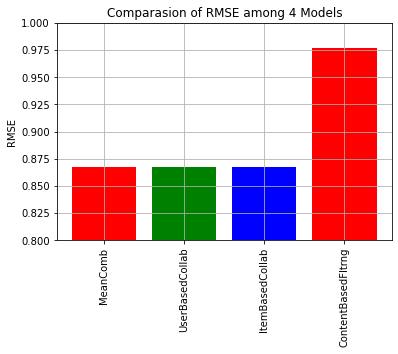

In [100]:
models = ['MeanComb','UserBasedCollab', 'ItemBasedCollab','ContentBasedFltrng']
rmses = [rmse_mc, rmse_ubc, rmse_ibc, rmse_cbf]
colors = ['r','g', 'b']
plt.bar(models, rmses, color=colors)
plt.ylim(0.8, 1.0)
plt.grid(True)
plt.ylabel('RMSE')
plt.title('Comparasion of RMSE among 4 Models')
plt.xticks(rotation=90)
plt.show()

We can see that the two collaborative filtering gives similar results as the mean combination model. But the content based filtering gives a much worse performance. 

So We will stop using those models. Instead, we will use the SVD++ model from Surprise in our further steps.